In [ ]:
## Persistence -- ability to save and restore the state of a workflow over time

## how to perform 1. add checkpointer to  each step

In [ ]:
## Task -- generate a joke on given topic and then explanation of joke

In [39]:
from typing import TypedDict,Literal,Annotated

from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()
groq_api=os.getenv('groq_api')
llm=ChatGroq(model='gemma2-9b-it',api_key=groq_api)
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel,Field
import operator
from langchain_core.messages import HumanMessage,SystemMessage,BaseMessage
from langgraph.checkpoint.memory import InMemorySaver



In [4]:
class JokeState(TypedDict):
    topic:str
    joke:str
    explanation:str

In [5]:
def generate_joke(state:JokeState):
    topic=state['topic']

    prompt=f'Generate a short and funny joke on the topic of {topic}'
    output=llm.invoke(prompt).content
    return {'joke':output}

def generate_explantion(state:JokeState):
    prompt=f'Explain this joke {state['joke']} in easy words'
    output=llm.invoke(prompt).content
    return {'explanation':output}

In [ ]:
graph=StateGraph(JokeState)

graph.add_node('generate_joke',generate_joke)
graph.add_node('generate_explanation',generate_explantion)

graph.add_edge(START,'generate_joke')
graph.add_edge('generate_joke','generate_explanation')
graph.add_edge('generate_explanation',END)

checkpoint=InMemorySaver()
workflow=graph.compile(checkpointer=checkpoint)

In [16]:
# workflow

In [28]:
thread_id=2
config={'configurable':{'thread_id':thread_id}}
init_state={'topic':'wwe'}

output=workflow.invoke(init_state,config=config)

In [29]:
output

{'topic': 'wwe',
 'joke': 'Why did the wrestler bring a ladder to the library? \n\nHe heard there was a book on how to "climb the ranks"!  😂 \n',
 'explanation': 'This joke plays on two different meanings of the phrase "climb the ranks."\n\n* **Wrestlers** try to climb the ranks in their sport by winning matches and becoming more famous.\n\n* **Libraries** have books on many topics, including how to succeed in life. \n\nThe joke is funny because it makes a silly connection between these two ideas. The wrestler thinks the library has a book with literal instructions on how to climb a ladder, when it really means achieving a higher position or status.  \n\n\nLet me know if you\'d like to hear another joke! 😊 \n'}

In [30]:
workflow.get_state(config=config)

StateSnapshot(values={'topic': 'wwe', 'joke': 'Why did the wrestler bring a ladder to the library? \n\nHe heard there was a book on how to "climb the ranks"!  😂 \n', 'explanation': 'This joke plays on two different meanings of the phrase "climb the ranks."\n\n* **Wrestlers** try to climb the ranks in their sport by winning matches and becoming more famous.\n\n* **Libraries** have books on many topics, including how to succeed in life. \n\nThe joke is funny because it makes a silly connection between these two ideas. The wrestler thinks the library has a book with literal instructions on how to climb a ladder, when it really means achieving a higher position or status.  \n\n\nLet me know if you\'d like to hear another joke! 😊 \n'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0746c5-355c-647e-8006-2a617091329f'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}}, created_at='2025-08-08T15:28:25.190476+00:00', parent_config={'configura

In [31]:
list(workflow.get_state_history(config=config))

[StateSnapshot(values={'topic': 'wwe', 'joke': 'Why did the wrestler bring a ladder to the library? \n\nHe heard there was a book on how to "climb the ranks"!  😂 \n', 'explanation': 'This joke plays on two different meanings of the phrase "climb the ranks."\n\n* **Wrestlers** try to climb the ranks in their sport by winning matches and becoming more famous.\n\n* **Libraries** have books on many topics, including how to succeed in life. \n\nThe joke is funny because it makes a silly connection between these two ideas. The wrestler thinks the library has a book with literal instructions on how to climb a ladder, when it really means achieving a higher position or status.  \n\n\nLet me know if you\'d like to hear another joke! 😊 \n'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0746c5-355c-647e-8006-2a617091329f'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}}, created_at='2025-08-08T15:28:25.190476+00:00', parent_config={'configur

## Time Travel --- we can go in past(prv state) and run same code 

In [33]:
workflow.get_state(config={'configurable':{'thread_id':2,"checkpoint_id":'1f0746c1-9f5c-6300-8000-8417d0a0b22a'}})

StateSnapshot(values={'topic': 'cricket'}, next=('generate_joke',), config={'configurable': {'thread_id': '2', 'checkpoint_id': '1f0746c1-9f5c-6300-8000-8417d0a0b22a'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-08T15:26:48.931192+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0746c1-9f5a-6c26-bfff-ba6f0b7dfa81'}}, tasks=(PregelTask(id='b9d54f6b-acb5-d22a-5090-0e7a0b2a31da', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result={'joke': 'Why did the cricket player bring a ladder to the match? \n\nBecause he heard the wickets were high! 🏏😂  \n'}),), interrupts=())

In [34]:
workflow.get_state(config={'configurable':{'thread_id':2,"checkpoint_id":'1f0746c1-a4e7-6180-8001-d92f4a0df5d6'}})

StateSnapshot(values={'topic': 'cricket', 'joke': 'Why did the cricket player bring a ladder to the match? \n\nBecause he heard the wickets were high! 🏏😂  \n'}, next=('generate_explanation',), config={'configurable': {'thread_id': '2', 'checkpoint_id': '1f0746c1-a4e7-6180-8001-d92f4a0df5d6'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-08T15:26:49.512341+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0746c1-9f5c-6300-8000-8417d0a0b22a'}}, tasks=(PregelTask(id='6079fbb1-9e39-78fc-88ae-c6247bff8c26', name='generate_explanation', path=('__pregel_pull', 'generate_explanation'), error=None, interrupts=(), state=None, result={'explanation': 'This joke plays on the words "high" having two meanings.  \n\n* **High (score):** In cricket, you want to score lots of runs. So, "high wickets" could mean a really good score.\n* **High (as in up):** Wickets are the three sticks in cricket that batters try to hit the bal

In [59]:
workflow.invoke(None,config={'configurable':{'thread_id':2,"checkpoint_id":'1f0746c1-9f5c-6300-8000-8417d0a0b22a'}}) ## run from that checkpoint if

{'topic': 'cricket',
 'joke': 'Why did the cricketer bring a ladder to the match? \n\nBecause he heard the bowling was going to be high! 🏏 😂  \n',
 'explanation': 'This joke plays on the words "high" having two meanings. \n\n* **High in the air:**  Cricket bowlers throw the ball, and sometimes they throw it really high.\n* **Good quality:**  We sometimes say something is "high" quality if it\'s really good.\n\nThe joke is funny because the cricketer brought a ladder expecting the bowling to be *really high in the air*, but actually he might have heard the bowling was going to be *really good*! \n\n'}

## Fault Tolerance

In [49]:
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str

In [50]:
import time
def step_1(state: CrashState) -> CrashState:
    print("✅ Step 1 executed")
    return {"step1": "done", "input": state["input"]}

def step_2(state: CrashState) -> CrashState:
    print("⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
    time.sleep(30)  # Simulate long-running hang
    return {"step2": "done"}

def step_3(state: CrashState) -> CrashState:
    print("✅ Step 3 executed")
    return {"done": True}

In [51]:

builder = StateGraph(CrashState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.set_entry_point("step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

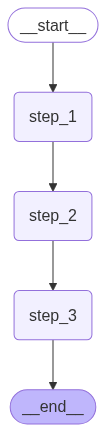

In [52]:
graph

In [53]:
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")

▶️ Running graph: Please manually interrupt during Step 2...
✅ Step 1 executed
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)
❌ Kernel manually interrupted (crash simulated).


In [54]:
list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0746e9-7978-6828-8001-5d142ded1483'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-08T15:44:38.700020+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0746e9-7975-68e4-8000-fe1aa4c5a74c'}}, tasks=(PregelTask(id='43a0ae72-caf8-463d-80ac-2dd232416491', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step_1',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0746e9-7975-68e4-8000-fe1aa4c5a74c'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-08T15:44:38.698811+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'ch

In [56]:
# Re-run to show fault-tolerant resume
print("\n🔁 Re-running the graph to demonstrate fault tolerance...")
final_state = graph.invoke(None, config={"configurable": {"thread_id": 'thread-1'}}) ### to restart give input as none
print("\n✅ Final State:", final_state)


🔁 Re-running the graph to demonstrate fault tolerance...

✅ Final State: {'input': 'start', 'step1': 'done', 'step2': 'done'}


In [57]:
list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0746ea-ee3b-645c-8003-d4bd760c45b1'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-08-08T15:45:17.786819+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0746ea-ee38-6798-8002-7aa243a8937b'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step_3',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0746ea-ee38-6798-8002-7aa243a8937b'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-08-08T15:45:17.785639+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0746e9-7978-6828-8001-5d142ded1483'}}, tasks=(PregelTask(id='f299506a-1728-64c2-f8f6-c8de768925a